# GDP and life expectancy

Richer countries can afford to invest more on healthcare, on work and road safety, and other measures that reduce mortality. On the other hand, richer countries may have less healthy lifestyles. Is there any relation between the wealth of a country and the life expectancy of its inhabitants?

The following analysis checks whether there is any correlation between the total gross domestic product (GDP) of a country in 2013 and the life expectancy of people born in that country in 2013.

## Getting the data

Two datasets of the World Bank are considered. One dataset, available at <http://data.worldbank.org/indicator/NY.GDP.MKTP.CD>, lists the GDP of the world's countries in current US dollars, for various years. The use of a common currency allows us to compare GDP values across countries. The other dataset, available at <http://data.worldbank.org/indicator/SP.DYN.LE00.IN>, lists the life expectancy of the world's countries. The datasets were downloaded as CSV files in March 2016.

In [1]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

import pandas as pd

YEAR = 2013
GDP_INDICATOR = 'NY.GDP.MKTP.CD'
gdpReset = pd.read_csv('WB GDP 2013.csv')

LIFE_INDICATOR = 'SP.DYN.LE00.IN'
lifeReset = pd.read_csv('WB LE 2013.csv')
lifeReset.head()

,country,year,SP.DYN.LE00.IN
0,Arab World,2013,70.631305
1,Caribbean small states,2013,71.901964
2,Central Europe and the Baltics,2013,76.127583
3,East Asia & Pacific (all income levels),2013,74.604619
4,East Asia & Pacific (developing only),2013,73.657617


## Cleaning the data

Inspecting the data with `head()` and `tail()` shows that:

1. the first 34 rows are aggregated data, for the Arab World, the Caribbean small states, and other country groups used by the World Bank;
- GDP and life expectancy values are missing for some countries.

The data is therefore cleaned by:
1. removing the first 34 rows;
- removing rows with unavailable values.

In [2]:
gdpCountries = gdpReset[34:].dropna()
lifeCountries = lifeReset[34:].dropna()

## Transforming the data

The World Bank reports GDP in US dollars and cents. To make the data easier to read, the GDP is converted to millions of British pounds (the author's local currency) with the following auxiliary functions, using the average 2013 dollar-to-pound conversion rate provided by <http://www.ukforex.co.uk/forex-tools/historical-rate-tools/yearly-average-rates>. 

In [3]:
def roundToMillions (value):
    return round(value / 1000000)

def usdToGBP (usd):
    return usd / 1.564768

GDP = 'GDP (£m)'
gdpCountries[GDP] = gdpCountries[GDP_INDICATOR].apply(usdToGBP).apply(roundToMillions)
gdpCountries.head()

,country,year,NY.GDP.MKTP.CD,GDP (£m)
34,Afghanistan,2013,2.045894e+10,13075
35,Albania,2013,1.278103e+10,8168
36,Algeria,2013,2.097035e+11,134016
38,Andorra,2013,3.249101e+09,2076
39,Angola,2013,1.383568e+11,88420


The unnecessary columns can be dropped.

In [4]:
COUNTRY = 'country'
headings = [COUNTRY, GDP]
gdpClean = gdpCountries[headings]
gdpClean.head()

,country,GDP (£m)
34,Afghanistan,13075
35,Albania,8168
36,Algeria,134016
38,Andorra,2076
39,Angola,88420


The World Bank reports the life expectancy with several decimal places. After rounding, the original column is discarded.

In [5]:
LIFE = 'Life expectancy (years)'
lifeCountries[LIFE] = lifeCountries[LIFE_INDICATOR].apply(round)
headings = [COUNTRY, LIFE]
lifeClean = lifeCountries[headings]
lifeClean.head()

,country,Life expectancy (years)
34,Afghanistan,60
35,Albania,78
36,Algeria,75
39,Angola,52
40,Antigua and Barbuda,76


## Combining the data

The tables are combined through an inner join on the common 'country' column. 

In [6]:
gdpVsLife = pd.merge(gdpClean, lifeClean, on=COUNTRY, how='inner')
gdpVsLife.head()

,country,GDP (£m),Life expectancy (years)
0,Afghanistan,13075,60
1,Albania,8168,78
2,Algeria,134016,75
3,Angola,88420,52
4,Antigua and Barbuda,767,76


## Calculating the correlation

To measure if the life expectancy and the GDP grow together, the Spearman rank correlation coefficient is used. It is a number from -1 (perfect inverse rank correlation: if one indicator increases, the other decreases) to 1 (perfect direct rank correlation: if one indicator increases, so does the other), with 0 meaning there is no rank correlation. A perfect correlation doesn't imply any cause-effect relation between the two indicators. A p-value below 0.05 means the correlation is statistically significant.

In [7]:
from scipy.stats import spearmanr

gdpColumn = gdpVsLife[GDP]
lifeColumn = gdpVsLife[LIFE]
(correlation, pValue) = spearmanr(gdpColumn, lifeColumn)
print('The correlation is', correlation)
if pValue < 0.05:
    print('It is statistically significant.')
else:
    print('It is not statistically significant.')

The correlation is 0.5010232389671027
It is statistically significant.


The value shows a direct correlation, i.e. richer countries tend to have longer life expectancy, but it is not very strong.

## Showing the data

Measures of correlation can be misleading, so it is best to see the overall picture with a scatterplot. The GDP axis uses a logarithmic scale to better display the vast range of GDP values, from a few million to several billion (million of million) pounds.

<AxesSubplot:xlabel='GDP (£m)', ylabel='Life expectancy (years)'>

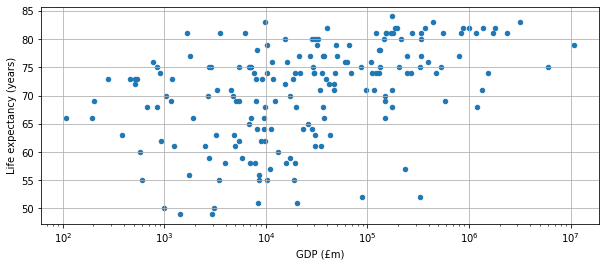

In [8]:
%matplotlib inline
gdpVsLife.plot(x=GDP, y=LIFE, kind='scatter', grid=True, logx=True, figsize=(10, 4))

The plot shows there is no clear correlation: there are rich countries with low life expectancy, poor countries with high expectancy, and countries with around 10 thousand (10<sup>4</sup>) million pounds GDP have almost the full range of values, from below 50 to over 80 years. Towards the lower and higher end of GDP, the variation diminishes. Above 40 thousand million pounds of GDP (3rd tick mark to the right of 10<sup>4</sup>), most countries have an expectancy of 70 years or more, whilst below that threshold most countries' life expectancy is below 70 years. 

Comparing the 10 poorest countries and the 10 countries with the lowest life expectancy shows that total GDP is a rather crude measure. The population size should be taken into account for a more precise definiton of what 'poor' and 'rich' means. Furthermore, looking at the countries below, droughts and internal conflicts may also play a role in life expectancy. 

In [9]:
# the 10 countries with lowest GDP
gdpVsLife.sort_values(GDP).head(10)

,country,GDP (£m),Life expectancy (years)
87,Kiribati,108,66
141,Sao Tome and Principe,195,66
111,"Micronesia, Fed. Sts.",202,69
168,Tonga,277,73
37,Comoros,383,63
157,St. Vincent and the Grenadines,461,73
140,Samoa,509,73
180,Vanuatu,512,72
65,Grenada,538,73
60,"Gambia, The",578,60


In [10]:
# the 10 countries with lowest life expectancy
gdpVsLife.sort_values(LIFE).head(10)

,country,GDP (£m),Life expectancy (years)
95,Lesotho,1418,49
160,Swaziland,2916,49
32,Central African Republic,983,50
146,Sierra Leone,3092,50
33,Chad,8276,51
41,Cote d'Ivoire,19998,51
3,Angola,88420,52
124,Nigeria,329100,52
30,Cameroon,18896,55
153,South Sudan,8473,55


## Conclusions

To sum up, there is no strong correlation between a country's wealth and the life expectancy of its inhabitants: there is often a wide variation of life expectancy for countries with similar GDP, countries with the lowest life expectancy are not the poorest countries, and countries with the highest expectancy are not the richest countries. Nevertheless there is some relationship, because the vast majority of countries with a life expectancy below 70 years is on the left half of the scatterplot.

Using the [NY.GDP.PCAP.PP.CD](http://data.worldbank.org/indicator/NY.GDP.PCAP.PP.CD) indicator, GDP per capita in current 'international dollars', would make for a better like-for-like comparison between countries, because it would take population and purchasing power into account. Using more specific data, like expediture on health, could also lead to a better analysis.

## NOW IS YOUR TURN


## GOOD LUCK!

In [50]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

import pandas as pd

YEAR = 2018
INCOME_INDICATOR = 'NY.GDP.PCAP.PP.CD'
incomeReset = pd.read_csv('WB PCI 2018.csv')

HPC_INDICATOR = '2018 [YR2018]'
healthReset = pd.read_csv('WB HPC 2018.csv')
healthReset.head()

,Series Name,Series Code,Country Name,Country Code,2018 [YR2018]
0,"External health expenditure per capita, PPP (c...",SH.XPD.EHEX.PP.CD,Afghanistan,AFG,30.65452385
1,"External health expenditure per capita, PPP (c...",SH.XPD.EHEX.PP.CD,Albania,ALB,9.40255356
2,"External health expenditure per capita, PPP (c...",SH.XPD.EHEX.PP.CD,Algeria,DZA,0.25948596
3,"External health expenditure per capita, PPP (c...",SH.XPD.EHEX.PP.CD,American Samoa,ASM,..
4,"External health expenditure per capita, PPP (c...",SH.XPD.EHEX.PP.CD,Andorra,AND,0


In [51]:
YEAR = 2018
INCOME_INDICATOR = 'NY.GDP.PCAP.PP.CD'
incomeReset = pd.read_csv('WB PCI 2018.csv')
incomeReset.head()

,Series Name,Series Code,Country Name,Country Code,NY.GDP.PCAP.CD
0,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,Afghanistan,AFG,2082.635648
1,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,Albania,ALB,13546.48169
2,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,Algeria,DZA,11921.72533
3,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,American Samoa,ASM,..
4,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,Andorra,AND,..


In [52]:
incomeCountries = incomeReset[0:].dropna()
healthCountries = healthReset[0:].dropna()

In [54]:
COUNTRY = 'Country Name'
INCOME = 'NY.GDP.PCAP.CD'
headings = [COUNTRY, INCOME]
incomeReset = pd.read_csv('WB PCI 2018.csv')
incomeClean = incomeCountries[headings]
incomeClean.head()

,Country Name,NY.GDP.PCAP.CD
0,Afghanistan,2082.635648
1,Albania,13546.48169
2,Algeria,11921.72533
3,American Samoa,..
4,Andorra,..


In [55]:
COUNTRY = 'Country Name'
HEALTH = '2018 [YR2018]'
headings = [COUNTRY, HEALTH]
healthReset = pd.read_csv('WB HPC 2018.csv')
healthClean = healthCountries[headings]
healthClean.head()

,Country Name,2018 [YR2018]
0,Afghanistan,30.65452385
1,Albania,9.40255356
2,Algeria,0.25948596
3,American Samoa,..
4,Andorra,0


In [56]:
incomeVshealth = pd.merge(incomeClean, healthClean, on=COUNTRY, how='inner')
incomeVshealth.head()

,Country Name,NY.GDP.PCAP.CD,2018 [YR2018]
0,Afghanistan,2082.635648,30.65452385
1,Albania,13546.48169,9.40255356
2,Algeria,11921.72533,0.25948596
3,American Samoa,..,..
4,Andorra,..,0


In [57]:
incomeVshealth.columns

Index(['Country Name', 'NY.GDP.PCAP.CD', '2018 [YR2018]'], dtype='object')

In [58]:
from scipy.stats import spearmanr

incomeColumn = incomeVshealth[INCOME]
healthColumn = incomeVshealth[HEALTH]
(correlation, pValue) = spearmanr(incomeColumn, healthColumn)
print('The correlation is', correlation)
if pValue < 0.05:
    print('It is statistically significant.')
else:
    print('It is not statistically significant.')

The correlation is 0.037337209195977696
It is not statistically significant.


<AxesSubplot:xlabel='NY.GDP.PCAP.CD', ylabel='2018 [YR2018]'>

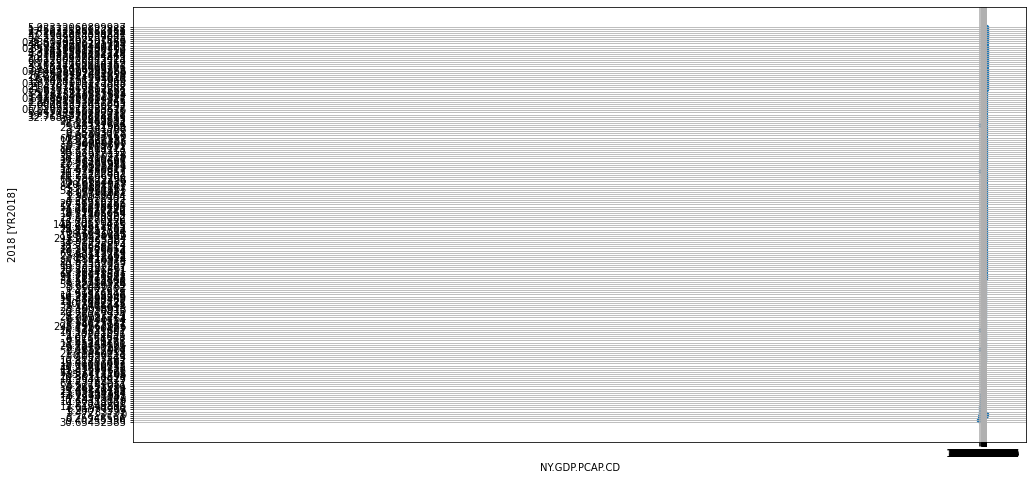

In [59]:
%matplotlib inline
incomeVshealth.plot(x=INCOME, y=HEALTH, kind='scatter', grid=True, logx=True, figsize=(16, 8))

In [60]:
# the 10 countries with lowest income
incomeVshealth.sort_values(INCOME).head(10)

,Country Name,NY.GDP.PCAP.CD,2018 [YR2018]
178,South Sudan,..,70.92980957
212,Virgin Islands (U.S.),..,..
210,"Venezuela, RB",..,0.1132664
39,Channel Islands,..,..
189,Syrian Arab Republic,..,..
183,St. Martin (French part),..,..
49,Cuba,..,2.18527007
61,Eritrea,..,26.37631607
146,Northern Mariana Islands,..,..
65,Faroe Islands,..,..


In [61]:
incomeVshealth.sort_values(INCOME).tail(10)

,Country Name,NY.GDP.PCAP.CD,2018 [YR2018]
80,Guatemala,8665.347261,8.12488842
155,Philippines,8720.607379,2.99058151
63,Eswatini,8725.1702,295.79663086
59,El Salvador,8820.838904,1.20742655
23,Bolivia,8863.349174,9.28551579
176,Somalia,887.5761733,..
159,Qatar,93154.23488,0
222,Early-demographic dividend,9422.781919,5.473677850297
37,Central African Republic,955.5137443,49.83828735
97,Jamaica,9968.594493,8.35284996


In [62]:
# the 10 countries with lowest health expenditure
incomeVshealth.sort_values(HEALTH).head(5)

,Country Name,NY.GDP.PCAP.CD,2018 [YR2018]
146,Northern Mariana Islands,..,..
158,Puerto Rico,35122.87966,..
27,British Virgin Islands,..,..
252,Not classified,..,..
140,New Caledonia,..,..
